# VGG Chimpanzee tracking

This project provides an interface to track chimpanzees in the wild.
It will detect the chimpanzees in video files.  It is based in the
following projects:

- [Count, Crop and Recognise: Fine-Grained Recognition in the
  Wild](https://www.robots.ox.ac.uk/~vgg/research/ccr/) -
  [[paper]](http://www.robots.ox.ac.uk/~vgg/publications/2019/Bain19/bain19.pdf)

- [Chimpanzee face recognition from videos in the wild using deep
  learning](https://www.robots.ox.ac.uk/~vgg/research/ChimpanzeeFaces/) -
  [[paper]](https://advances.sciencemag.org/content/advances/5/9/eaaw0736.full.pdf)


## 1 - Read Me First


This project is a [Jupyter](https://jupyter.org/) notebook to track
chimpanzees in the wild and was designed to run in [Google
Colab](https://colab.research.google.com/).  If you are not reading
this notebook in Google Colab, click
[here](https://colab.research.google.com/github/ox-vgg/chimpanzee-tracking/blob/main/tracking.ipynb).


### 1.1 - What is, and how to use, a Jupyter notebook

A Jupyter notebook is a series of "cells".  Each cell contains either
text (like this one) or code (like others below).  A cell that
contains code will have a "Run cell" button on the left side like this
"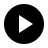".
When you click the "Run cell" button, the code in that cell will run
and when it finishes, a green check mark appears next to the "Run
cell" button".  You need to wait for the code in that cell to finish
before "running" the next cell.


### 1.2 - Particulars of this notebook

This notebook was designed to run in Google Colab and to analyse
videos in Google Drive.  It will also save back the analysis results
in Google Drive.  As such, it requires a Google account.


### 1.3 - Results files

This notebook will save all the results in a single directory.  It
will generate the following files:

- `frames` - a directory with the individual video frames.  You may
  want to delete them after validating the results.  They take up a
  lot of space and can be regenerated later

- `detections.pkl` - the initial detections in [Python's pickle
  format](https://docs.python.org/3/library/pickle.html).

- `results-via-project.json` - the final detections as a
  [VIA](https://www.robots.ox.ac.uk/~vgg/software/via/) project.  This
  requires the images in the `frames` directory.

- `results.csv` - the final detections in CSV format.

Note that none of those files includes the video filename.  As such,
our recommendation is to create a results directory for each video.


### 1.4 - GPU access

A GPU is required to run this pipeline in a sensible manner.  For
example, without a GPU, a two minutes video will take close to two
hours to process.

By default, this notebook will run with a GPU.  However, it is
possible that you were not allocated one, typically because you've
used up all your GPU resources.  You can confirm this, and possibly
change it, manually.  To do that, navigate to "Edit" -> "Notebook
Settings" and select "GPU" from the "Hardware Accelerator" menu.


### 1.4 - Moving forward

You can run this notebook on Google Colab but if you have a large
collection of videos or if your videos are particularly long, you may
use up all of your Colab resources.  It may be worth running this in
your own computers.  Contact us if you need help to do that.
Alternatively, you purchase additional "compute units" with [Google
Colab Plans](https://colab.research.google.com/signup).


## 2 - Setup


In [ ]:
#@markdown ### 2.1 - Check for GPU access

#@markdown By default, this notebook will run with a GPU.  However, it
#@markdown is possible that you were not allocated one.  If you get a
#@markdown message saying that you do not have access to a GPU,
#@markdown navigate to "Edit" -> "Notebook Settings" and select "GPU"
#@markdown from the "Hardware Accelerator" menu.  Once you change it,
#@markdown you need to run this cell again.

gpu_info = !nvidia-smi --list-gpus
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    USE_GPU = False
    print('You are NOT connected to a GPU.  This will run very slow.')
    print('Consider reconnecting to a runtime with GPU access.')
else:
    USE_GPU = True
    print('You are connected to the following GPUs:')
    print(gpu_info)


In [ ]:
#@markdown ### 2.2 - Install and load dependencies

import contextlib
import glob
import io
import logging
import os
import os.path
import pickle
import requests
import subprocess
import sys
import tempfile
import warnings
from collections import defaultdict
from dataclasses import dataclass
from typing import Dict, List, NamedTuple, Optional
import unittest.mock

import cv2
import torch
import torch.cuda
import numpy as np
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchvision.models
import torchvision.transforms as transforms
from torch.autograd import Variable
import google.colab.drive

logging.basicConfig()
_logger = logging.getLogger()


## The SVT package https://www.robots.ox.ac.uk/~vgg/projects/seebibyte/software/svt/
# Despite the `--quiet` flag, it still prints out a mysterious
# "Preparing metadata (setup.py)" message so just redirect stdout.
# Important messages should go to stderr anyway.
!pip install --quiet git+https://gitlab.com/vgg/svt/ > /dev/null
import svt.detections
from svt.siamrpn_tracker import siamrpn_tracker


## The ssd.pytorch "package" (cloned into ssd_pytorch so it can imported)
# When we import stuff from ssd.pytorch, it import data.coco which reads a
# `HOME/data/coco/coco_labels.txt` (even though we don't need it).  We create
# an empty file so it doesn't fail to import.  We also need to add `HOME` to
# `data/config.py` or it will try to read from `/root`.  See
# https://github.com/amdegroot/ssd.pytorch/issues/571
!git clone --quiet \
  --single-branch --branch vgg-colab \
  https://github.com/carandraug/ssd.pytorch.git ssd_pytorch/
!echo 'HOME = "ssd_pytorch"' >> ssd_pytorch/data/config.py
!mkdir ssd_pytorch/data/coco
!touch ssd_pytorch/data/coco/coco_labels.txt
from ssd_pytorch.data import base_transform
from ssd_pytorch.ssd import build_ssd


In [ ]:
#@markdown ### 2.3 - Mount Google Drive

#@markdown When you run this cell, a dialog will appear about a
#@markdown request for access to your Google Drive Files.  This is
#@markdown required to access the videos for analysis and to then save
#@markdown the results.  Once you click on "Connect to Google Drive",
#@markdown a pop-up window will appear to choose a Google Account and
#@markdown then to allow access to "Google Drive for desktop".

google.colab.drive.mount('/content/drive')


In [ ]:
#@markdown ### 2.4 - Video File and Results Folder

#@markdown To find the correct path, open the "Files" menu in the left
#@markdown sidebar.  The `drive` directory contains your Google Drive
#@markdown files.  Navigate the files, right click on the wanted file
#@markdown or directory, and select "Copy path".  Then paste the path
#@markdown in this form and run this cell.

VIDEO_FILE = ''  #@param {type:"string"}
RESULTS_DIRECTORY = ''  #@param {type:"string"}


### 2.5 - Advanced Options

The cells hidden in this section configure the pipeline and includes
the advanced options.  In most cases you do not need to change them
and can collapse them (click on the arrow drop down on the left side
of this cell) and then click the "Run cell" to run all of the
collapsed cells in one go.


In [ ]:
#@markdown #### 2.5.1 - Chimpanzee Detection

#@markdown The detection step is the first step.  It detects the
#@markdown location of chimpanzees without attempting to identify who
#@markdown they are.

#@markdown A detection model is required.  You can either train
#@markdown your own model, or you can use one of our pre-trained
#@markdown models for
#@markdown [face](https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/face-model-ssd300_CFbootstrap_85000.pth)
#@markdown or
#@markdown [body](https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/body-model-ssd300_BFbootstrapBissau4p5k_prebossou_best.pth).
#@markdown Either way, you will need to upload the model to your
#@markdown Google Drive and specify its path here.
DETECTION_MODEL = 'https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/face-model-ssd300_CFbootstrap_85000.pth'  #@param {type: "string"}

#@markdown When the model detects a face or body, that detection is
#@markdown made with a confidence score.  Detections with a confidence
#@markdown score lower than the threshold are ignored.  If you set the
#@markdown threshold too high, you may loose some tracks but if you
#@markdown set it too low you may gain false tracks that need to be
#@markdown removed later.
DETECTION_THRESHOLD = 0.37  #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}


In [ ]:
#@markdown #### 2.5.2 - Chimpanzee Tracking

#@markdown The final step is to track the detected chimpanzees in the
#@markdown video.

#@markdown You will need to provide a model.  We recommend you use
#@markdown [this one](https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/tracking-model-20181031_e45.pth).
#@markdown You will also specify a path in your Google Drive.
TRACKING_MODEL = 'https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/tracking-model-20181031_e45.pth'  #@param {type: "string"}

MATCH_OVERLAP_THRESHOLD = 0.6 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

UNKNOWN_TRACK_ID_MARKER = -1


In [ ]:
#@markdown #### 2.5.3 - Verbosity

#@markdown How chatty do you want the notebook to be?  INFO is a good
#@markdown choice if you want to have a feeling for progress.
LOG_LEVEL = 'INFO'  #@param ["CRITICAL", "ERROR", "WARNING", "INFO", "DEBUG"]


In [ ]:
#@markdown #### 2.5.4 - The Final Setup Step

#@markdown Run this cell to perform the final pipeline setup based on
#@markdown the given options.

logging.getLogger().setLevel(LOG_LEVEL)

FRAMES_DIR = os.path.join(RESULTS_DIRECTORY, 'frames')
DETECTIONS_FPATH = os.path.join(RESULTS_DIRECTORY, 'detections.pkl')
VIA_PROJECT_FPATH = os.path.join(RESULTS_DIRECTORY, 'results-via-project.json')
CSV_FPATH = os.path.join(RESULTS_DIRECTORY, 'results.csv')

# These should never be true because USE_GPU was set automatically
# based on whether a GPU is available.
if USE_GPU and not torch.cuda.is_available():
    raise Exception('Your runtime does not have a GPU.')
elif torch.cuda.is_available() and not USE_GPU:
    _logger.warn('You have a GPU but chose to not use it.  Are you sure?')

if USE_GPU:
    DEFAULT_DEVICE = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    DEFAULT_DEVICE = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')


_logger.info('Will use %s device.', DEFAULT_DEVICE.upper())


def local_path_for_model(path: str) -> str:
    if path.startswith("https://"):
        downloaded_fh = tempfile.NamedTemporaryFile(delete=False)
        r = requests.get(path)
        downloaded_fh.write(r.content)
        downloaded_fh.flush()
        return downloaded_fh.name
    else:
        return path

DETECTION_MODEL_PATH = local_path_for_model(DETECTION_MODEL)
TRACKING_MODEL_PATH = local_path_for_model(TRACKING_MODEL)


face_id_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)


# Ideally this would be a NamedTuple and values couldn't change.
# However, in practice this is created in the detect phase and the
# id_score is filled in during the identify phase.  So we use
# dataclass and Optional.  Probably should be refactored.  But
# then, SVT also wants to access the values by position so
# dataclass brings its own problems.
@dataclass
class Detection:
    track_id: int
    x: float
    y: float
    w: float
    h: float
    id_score: Optional[float]


# TODO: why frame_id_to_filename only includes frames with detections?
# Can't we just check on the the list of detections that there's none?
#
# TODO: why do we convert the frame number to a string fo rkeys in the
# dict?  Why not just use an int?
#
# TODO: why return frame_id_to_filename (can't that be deduced?)
def detect(
    video_frames: List[str],
    detection_model_path: str,
    visual_threshold: float,
):
    if visual_threshold < 0.0 or visual_threshold > 1.0:
        raise ValueError(
            'visual_threshold needs to be a number between 0.0 and 1.0'
        )

    num_classes = 2  # +1 background
    net = build_ssd("test", 300, num_classes)
    net.load_state_dict(
        torch.load(detection_model_path, map_location=DEFAULT_DEVICE)
    )
    net.eval()
    net = net.to(DEFAULT_DEVICE)

    # XXX: Can't we do the benchmark just once and then save it?
    if USE_GPU:
        cudnn.benchmark = True

    _logger.info('Finished loading model %s', detection_model_path)

    _logger.info('Starting detection phase')

    # init this important variables
    frame_id_to_filename: Dict[str, str] = {}
    frame_detections: Dict[str, Dict[str, Detection]] = defaultdict(dict)

    # Go through frame list
    for frame_index, frame_fpath in enumerate(video_frames):
        frame_id = str(frame_index)  # XXX: Why?  Why are we not using the int?

        if frame_index % 1000 == 0:
            _logger.info(
                'Starting to process images %d to %d',
                frame_index,
                min(frame_index + 1000 - 1, len(video_frames) - 1),
            )

        # Acquire image
        img = cv2.imread(frame_fpath)

        # Apply transforms to the image
        transformed = base_transform(img, net.size, [104, 117, 123])
        transformed = torch.from_numpy(transformed).permute(2, 0, 1)
        transformed = Variable(transformed.unsqueeze(0))
        transformed = transformed.to(DEFAULT_DEVICE)

        # Send image through network
        net_out = net(transformed)  # run detector
        net_detections = net_out.data

        # Scale each detection back up to the image
        scale = torch.Tensor(
            [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]
        )
        pred_num = 0
        for i in range(net_detections.size(1)):
            j = 0
            while net_detections[0, i, j, 0] >= visual_threshold:
                score = net_detections[0, i, j, 0]
                pt = (net_detections[0, i, j, 1:] * scale).cpu().numpy()
                coords = (
                    max(float(pt[0]), 0.0),
                    max(float(pt[1]), 0.0),
                    min(float(pt[2]), img.shape[1]),
                    min(float(pt[3]), img.shape[0]),
                )
                if coords[2] - coords[0] >= 1 and coords[3] - coords[1] >= 1:
                    if pred_num == 0:
                        # We found at least one prediction, so add the
                        # image to the filename dict.
                        frame_id_to_filename[frame_id] = frame_fpath

                    # XXX: original code had the option to load
                    # face_id_score from a previous run but this makes
                    # very little sense now?

                    # Save detections to list ...
                    a_detection = Detection(
                        track_id=UNKNOWN_TRACK_ID_MARKER,
                        x=coords[0],
                        y=coords[1],
                        w=coords[2] - coords[0],
                        h=coords[3] - coords[1],
                        id_score=None,
                    )

                    frame_detections[frame_id][str(pred_num)] = a_detection
                    pred_num += 1
                j += 1

    _logger.info('Finished detections')
    return frame_detections, frame_id_to_filename


# XXX: this is not tested because we don't have a face_id_model yet.
def identify_faces(
    detections: Dict[str, Dict[str, Detection]],
    frame_id_to_filename: Dict[str, str],
    face_id_model_fpath: str,
):

    face_id_model = torchvision.models.resnet18()
    face_id_model.fc = nn.Linear(512, FACE_ID_CLASSES)
    face_id_checkpoint = torch.load(face_id_model_fpath)

    face_id_model = nn.DataParallel(face_id_model).cuda()
    face_id_model.load_state_dict(face_id_checkpoint["state_dict"])

    face_id_model.eval()
    _logger.info('Finished loading model %s', face_id_model_fpath)
    _logger.info('Starting face identification phase')

    cudnn.benchmark = True

    im_index_c = 0
    for frame_id, frame_fpath in frame_id_to_filename.items():

        if im_index_c % 1000 == 0:
            _logger.info(
                'Starting to process images %d to %d',
                im_index_c,
                min(im_index_c + 1000 - 1, len(frame_id_to_filename) - 1),
            )
        im_index_c += 1

        # Acquire image (yes, again)
        img = cv2.imread(frame_fpath)

        for detection in detections[frame_id].values():
            # Crop image to detection
            x_end = detection.x + detection.w
            y_end = detection.y + detection.h
            crop_img = img[
                int(detection.y) : int(y_end),
                int(detection.x) : int(x_end),
                :,
            ]
            # Prepare face image for classification
            crop_img = cv2.resize(crop_img, (224, 224)).astype(np.float32)
            zero_one_range_img = cv2.normalize(
                crop_img,
                None,
                alpha=0,
                beta=1,
                norm_type=cv2.NORM_MINMAX,
                dtype=cv2.CV_32F,
            )
            torch_permuted_img = torch.from_numpy(zero_one_range_img).permute(
                2, 0, 1
            )
            crop_img_normalized = face_id_normalize(torch_permuted_img)
            transformed = Variable(crop_img_normalized.unsqueeze(0))
            # run face classifier
            face_id_vector = face_id_model(transformed)

            # Max's hack for bringing the results down to 0-1 range
            face_id_vector = nn.Softmax()(face_id_vector)

            # keep only relevant output + move to cpu + detach
            face_id_vector_keep = (
                face_id_vector[0][: len(FACE_IDENTIFICATION_MAP)].cpu().detach().numpy()
            )

            # save face_id_scores
            detection.id_score = face_id_vector_keep

    _logger.info('Finished identification')


def track(
    detections: Dict[str, Dict[str, Detection]],
    frame_id_to_filename: Dict[str, str],
    tracking_model_path: str,
):
    _logger.info('Starting tracking phase')

    tracker_config = {
        'gpu_id': 0 if USE_GPU else -1,
        'verbose': True,
        'preload_model': True,
    }

    detections_match_config = {
        'match_overlap_threshold': MATCH_OVERLAP_THRESHOLD,
        'UNKNOWN_TRACK_ID_MARKER': UNKNOWN_TRACK_ID_MARKER,
        'frame_img_dir': '',
        'verbose': True,
        'via_project_name': VIDEO_FILE,
    }

    # We only use one shot, hence only shot_id 0.
    # XXX: Why are we using strings for int keys?
    shot_id = '0'
    detections4svt = {shot_id: {}}
    for frame_id, detections_values in detections.items():
        detections4svt[shot_id][frame_id] = {}
        for box_id, detection in detections_values.items():
            detections4svt[shot_id][frame_id][box_id] = [
                detection.track_id,
                detection.x,
                detection.y,
                detection.w,
                detection.h,
            ]

    # redirect sys.stdout to a buffer to capture the prints() in the code below
    svt_stdout = io.StringIO()
    with contextlib.redirect_stdout(svt_stdout):
        tracker = siamrpn_tracker(
            model_path=tracking_model_path, config=tracker_config
        )

        svt_detections = svt.detections.detections()
        svt_detections.read(detections4svt, frame_id_to_filename)
        svt_detections.match(tracker=tracker, config=detections_match_config)

    _logger.info(svt_stdout.getvalue())
    _logger.info('Finished tracking')
    return svt_detections


## 3 - Convert video to frames

The pipeline needs the video frames as individual image files.  This
cell will create a `frames` directory and save the individual images
there.  You may skip running this cell if you already have a `frames`
directory with images.  This cell will error if the `frames` directory
already exists to prevent overwriting any existing data.


In [ ]:
#@markdown Skip this cell if you already have the frames.  If you run
#@markdown this cell and the `frames` directory already exists, it
#@markdown errors to avoid overwriting any previous images.

os.makedirs(FRAMES_DIR, exist_ok=False)

logging2ffmpeg_loglevel = {
    'CRITICAL' : 'fatal',
    'ERROR' : 'error',
    'WARNING' : 'warning',
    'INFO' : 'info',
    'DEBUG' : 'debug',
}

ffmpeg_return = subprocess.run([
    'ffmpeg',
    '-i', VIDEO_FILE,
    '-vsync', 'vfr',
    '-q:v', '1',
    '-start_number', '0',
    '-filter:v', 'scale=iw:ih*(1/sar)',
    '-loglevel', logging2ffmpeg_loglevel[LOG_LEVEL],
    # FIXME: what if %06d.jpg is not enough and rools over?
    os.path.join(FRAMES_DIR, '%06d.jpg'),
], check=True)

_logger.info('Finished extracting individual frames to \'%s\'', FRAMES_DIR)


## 4 - Detection step

The detection of chimpanzees is the first step in the pipeline.  If
you have previously ran the detection you will have a `detections.pkl`
file in the results directory.  If so, skip the "detection" cell and
run the "load previous detections results" cell instead (you may need
to click in "2 cells hidden" to see them).


In [ ]:
#@markdown ### 4.1 - Run detection (option 1)

video_frames = sorted(glob.glob(os.path.join(FRAMES_DIR, '*.jpg')))

detections, frame_id_to_filename = detect(
    video_frames,
    DETECTION_MODEL_PATH,
    DETECTION_THRESHOLD,
)

with open(DETECTIONS_FPATH, 'wb') as fh:
    pickle.dump(
        {
            'detections': detections, 
            'frame_id_to_filename': frame_id_to_filename,
        },
        fh,
    )
_logger.info('Detection results saved to \'%s\'', DETECTIONS_FPATH)


In [ ]:
#@markdown ### 4.2 - Load previous detection results (option 2)

with open(DETECTIONS_FPATH, 'rb') as fh:
    loaded_detections = pickle.load(fh)

detections = loaded_detections['detections']
frame_id_to_filename = loaded_detections['frame_id_to_filename']
video_frames = list(frame_id_to_filename.values())

_logger.info('Detection results loaded from \'%s\'', DETECTIONS_FPATH)


## 5 - Tracking step


In [ ]:
#@markdown The final step in the pipeline is to track the detected
#@markdown chimpanzees in the video.  At the end of this step, the
#@markdown tracking results will be saved in a CSV file and as a
#@markdown [VIA](https://www.robots.ox.ac.uk/~vgg/software/via/)
#@markdown project.

svt_detections = track(
    detections,
    frame_id_to_filename,
    TRACKING_MODEL_PATH,
)

# XXX: So far we've been using absolute filepaths.  However, in the
# exported VIA project we want to use the filename only so that the
# images can be found by setting the project "Default Path".  This
# hack changes the filepath in the SVT internals.
svt_detections.frame_id_to_filename_map = {
    k: os.path.basename(v) for k, v in svt_detections.frame_id_to_filename_map.items()
}

svt_detections.export_via_project(
    VIA_PROJECT_FPATH,
    config={'frame_img_dir': FRAMES_DIR, 'via_project_name':''}
)
svt_detections.export_plain_csv(CSV_FPATH, {})


## 6 - Visualise tracking results

To see the tracking results, we recommend the use of
[VIA](https://www.robots.ox.ac.uk/~vgg/software/via/via.html).  You
will need to have the `results-via-project.json` and the `frames`
folder in your computer.

1. Download [VIA 2](https://www.robots.ox.ac.uk/~vgg/software/via/downloads/via-2.0.12.zip)
   and open it in your web browser.

2. Navigate to "Project" -> "Load" and select the
   `results-via-project.json` file.  A "File Not Found" error message will
   appear.  This means that VIA does not know where the images are.

3. Navigate to "Project" -> "Settings".  Set the "Default Path" to the
   `frames` directory in your computer.
